In [ ]:
import sys

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
# for example: sys.path += ['/content/drive/My Drive/cs146/hw2']
sys.path += ['/content/drive/Academics/2023-2024/EC_ENGR_M146/hw2_code']
### ========== TODO : END ========== ###

In [ ]:
#from nutil import *

"""
Author      : Yi-Chieh Wu, Sriram Sankararaman
Description : ML utilities
"""

# python libraries
import os

# numpy libraries
import numpy as np

# matplotlib libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

######################################################################
# global settings
######################################################################

mpl.lines.width = 2
mpl.axes.labelsize = 14


######################################################################
# classes
######################################################################

class Data :

    def __init__(self) :
        """
        Data class.

        Attributes
        --------------------
            X -- numpy array of shape (n,d), features
            y -- numpy array of shape (n,), targets
        """

        # n = number of examples, d = dimensionality
        self.X = None
        self.y = None

        self.Xnames = None
        self.yname = None

    def load(self, f, header=0, predict_col=-1) :
        """Load csv file into X array of features and y array of labels."""


        # load data
        with open(f, 'r') as fid :
            data = np.loadtxt(fid, delimiter=",", skiprows=header)

        # separate features and labels
        if predict_col is None :
            self.X = data[:,:]
            self.y = None
        else :
            if data.ndim > 1 :
                self.X = np.delete(data, predict_col, axis=1)
                self.y = data[:,predict_col]
            else :
                self.X = None
                self.y = data[:]

        # load feature and label names
        if header != 0:
            with open(f, 'r') as fid :
                header = fid.readline().rstrip().split(",")

            if predict_col is None :
                self.Xnames = header[:]
                self.yname = None
            else :
                if len(header) > 1 :
                    self.Xnames = np.delete(header, predict_col)
                    self.yname = header[predict_col]
                else :
                    self.Xnames = None
                    self.yname = header[0]
        else:
            self.Xnames = None
            self.yname = None


# helper functions
def load_data(filename, header=0, predict_col=-1) :
    """Load csv file into Data class."""
    data = Data()
    data.load(filename, header=header, predict_col=predict_col)
    return data

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve

In [ ]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        probability_zero = 0
        probability_one = 0
        for element in y:
            if element == 0:
                probability_zero += 1
            else:
                probability_one += 1
        probability_zero /= (len(y))
        probability_one /= (len(y))
        self.probabilities_ = {0: probability_zero, 1: probability_one}

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        y = []
        for i in range(len(X)):
            y.append(np.random.choice(list(self.probabilities_.keys()), p = list(self.probabilities_.values())))

        ### ========== TODO : END ========== ###

        return y


In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # part e:
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use StratifiedShuffleSplit (be careful of the parameters)
    splits = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    train_error = 0
    test_error = 0
    f1_score = 0
    for train_index, test_index in splits.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # Your code for training and evaluating the model goes here
      clf.fit(X_train, y_train)
      y_train_pred = clf.predict(X_train)
      train_error += 1 - metrics.accuracy_score(y_train, y_train_pred, normalize=True)

      y_test_pred = clf.predict(X_test)
      test_error += 1 - metrics.accuracy_score(y_test, y_test_pred, normalize=True)

      f1_score += metrics.f1_score(y_test, y_test_pred)


    train_error /= ntrials
    test_error /= ntrials
    f1_score /= ntrials
    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


In [ ]:
######################################################################
# main
######################################################################

# load adult_subsample dataset with correct file path

### ========== TODO : START ========== ###
# for example data_file =  "/content/drive/My Drive/cs146/hw1/adult_subsample.csv"
data_file = "/content/drive/My Drive/Academics/2023-2024/EC_ENGR_M146/hw2_code/adult_subsample.csv"
### ========== TODO : END ========== ###

data = load_data(data_file, header=1, predict_col=-1)

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


Plotting...


<Figure size 640x480 with 0 Axes>

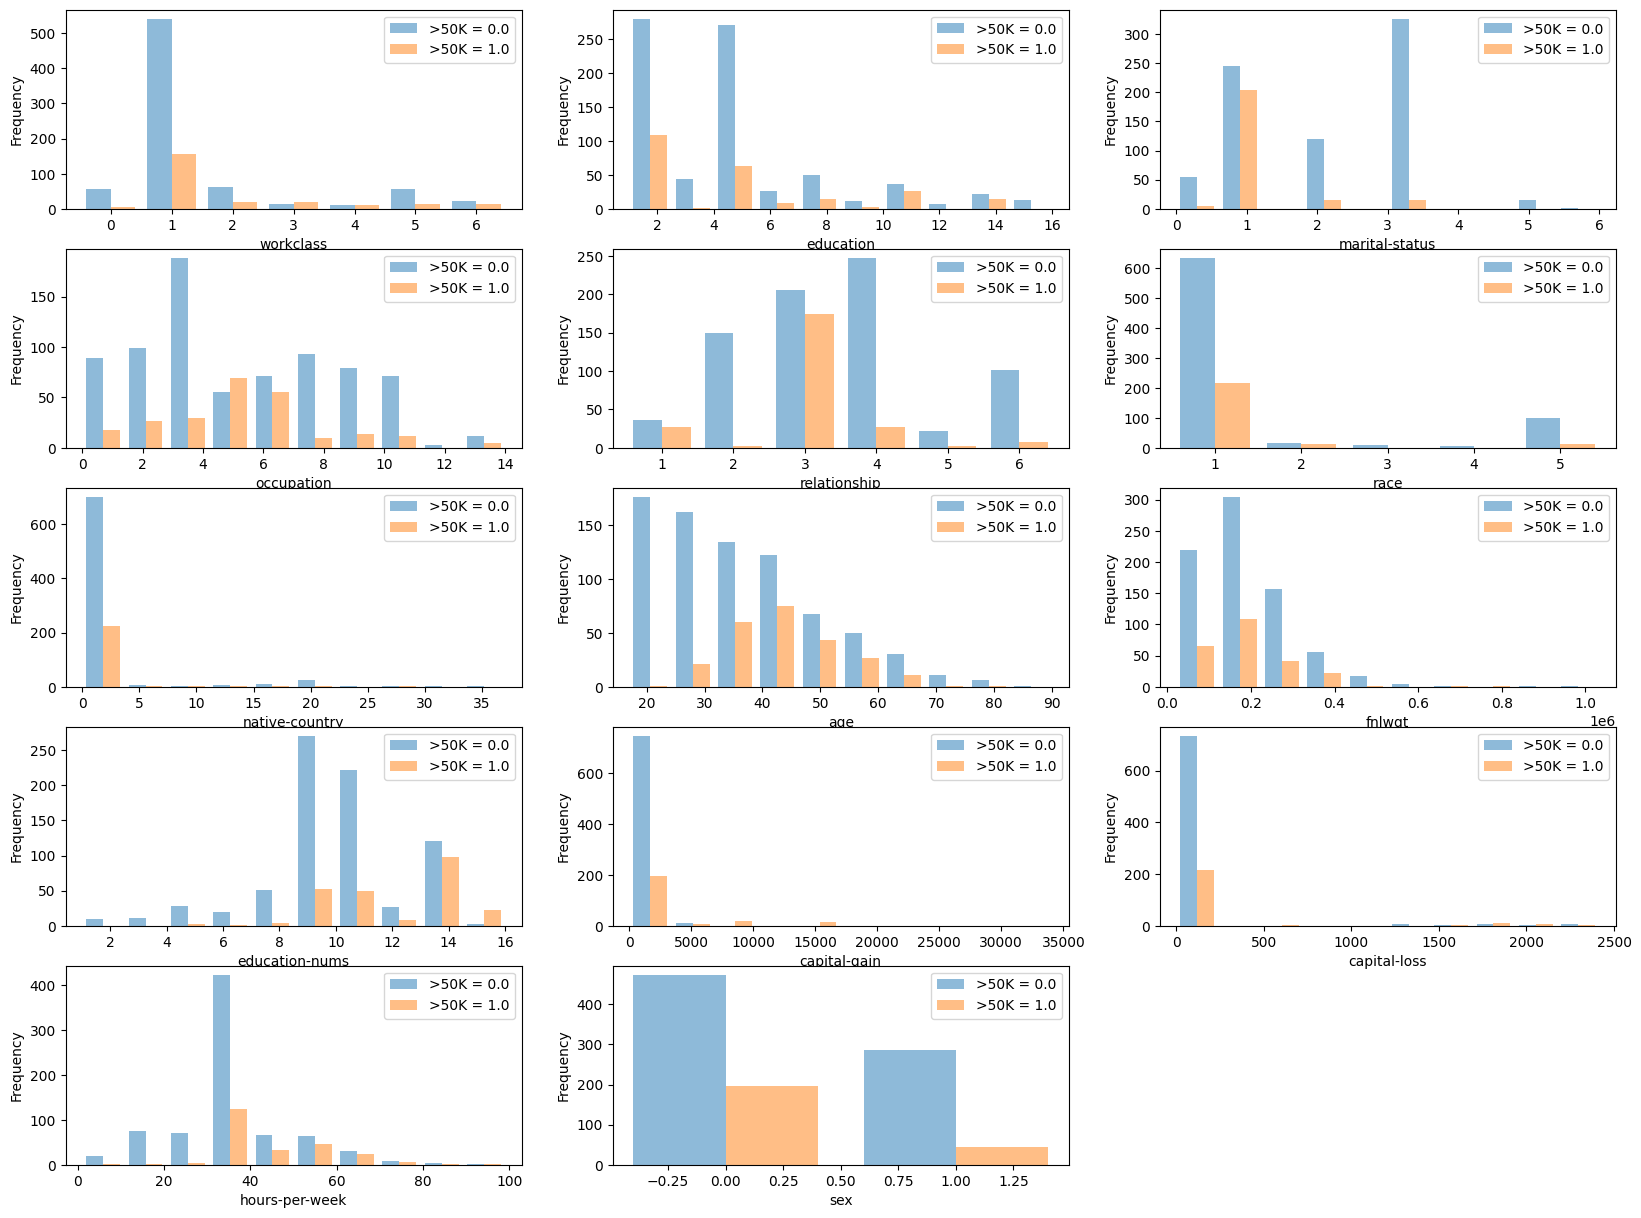

In [ ]:
plt.figure()
#========================================
# part a: plot histograms of each feature
print('Plotting...')
plot_histograms (X, y, Xnames=Xnames, yname=yname)

In [ ]:
#========================================
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.240


In [ ]:
### ========== TODO : START ========== ###
# part b: evaluate training error of Random classifier
print('Classifying using Random Classifier...')
clf = RandomClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

Classifying using Random Classifier...
	-- training error: 0.374


In [ ]:
### ========== TODO : START ========== ###
# part c: evaluate training error of Decision Tree classifier
print('Classifying using Decision Tree Classifier...')
clf = DecisionTreeClassifier(criterion='entropy') # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

Classifying using Decision Tree Classifier...
	-- training error: 0.000


In [ ]:
### ========== TODO : START ========== ###
# part d: evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 5, 7 for n_neighbors
print('Classifying using k-Nearest Neighbors Classifier with k = 3...')
clf = KNeighborsClassifier(n_neighbors=3) # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)


print('Classifying using k-Nearest Neighbors Classifier with k = 5...')
clf = KNeighborsClassifier(n_neighbors=5) # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

print('Classifying using k-Nearest Neighbors Classifier with k = 7...')
clf = KNeighborsClassifier(n_neighbors=7) # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

Classifying using k-Nearest Neighbors Classifier with k = 3...
	-- training error: 0.153
Classifying using k-Nearest Neighbors Classifier with k = 5...
	-- training error: 0.195
Classifying using k-Nearest Neighbors Classifier with k = 7...
	-- training error: 0.213


In [ ]:
### ========== TODO : START ========== ###
# part e: evaluate training error of Logistic Regression
# use lambda_ = 0.1, 1, 10 for n_neighbors
print('Classifying using Logistic Regression for lambda_ = 0.1...')
clf = LogisticRegression(C=10, random_state=0, max_iter = 1000) # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

print('Classifying using Logistic Regression for lambda_ = 1...')
clf = LogisticRegression(C=1, random_state=0, max_iter = 1000) # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

print('Classifying using Logistic Regression for lambda_ = 10...')
clf = LogisticRegression(C=0.1, random_state=0, max_iter = 1000) # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Logistic Regression for lambda_ = 0.1...
	-- training error: 0.208
Classifying using Logistic Regression for lambda_ = 1...
	-- training error: 0.208
Classifying using Logistic Regression for lambda_ = 10...
	-- training error: 0.220


In [ ]:
### ========== TODO : START ========== ###
# part f: use cross-validation to compute average training and test error of classifiers
print('Investigating various classifiers...')
print("Random Classifier:")
clf = RandomClassifier()
train_error, test_error, f1_score = error(clf, X, y, ntrials=100, test_size=0.15)
print("\t-- training error: ", train_error, "; test error: ", test_error, "; f1_score: ", f1_score)

print("Decision Tree Classifier:")
clf = DecisionTreeClassifier(criterion='entropy')
train_error, test_error, f1_score = error(clf, X, y, ntrials=100, test_size=0.15)
print("\t-- training error: ", train_error, "; test error: ", test_error, "; f1_score: ", f1_score)

print("K-Neighbors Classifier:")
clf = KNeighborsClassifier(n_neighbors=5)
train_error, test_error, f1_score = error(clf, X, y, ntrials=100, test_size=0.15)
print("\t-- training error: ", train_error, "; test error: ", test_error, "; f1_score: ", f1_score)

print("Logistic Regression:")
clf = LogisticRegression(C=1, random_state=0, max_iter = 1000)
train_error, test_error, f1_score = error(clf, X, y, ntrials=100, test_size=0.15)
print("\t-- training error: ", train_error, "; test error: ", test_error, "; f1_score: ", f1_score)
### ========== TODO : END ========== ###

Investigating various classifiers...
Random Classifier:
	-- training error:  0.3724000000000002 ; test error:  0.36666666666666664 ; f1_score:  0.24657534246575344
Decision Tree Classifier:
	-- training error:  0.0 ; test error:  0.20199999999999999 ; f1_score:  0.5792998668730674
K-Neighbors Classifier:
	-- training error:  0.19977647058823547 ; test error:  0.2544 ; f1_score:  0.16237812565447884
Logistic Regression:
	-- training error:  0.207364705882353 ; test error:  0.21240000000000003 ; f1_score:  0.33209161548487187


Finding the best k...
best k value:  17  and corresponding (average) validation score:  0.7609999999999999


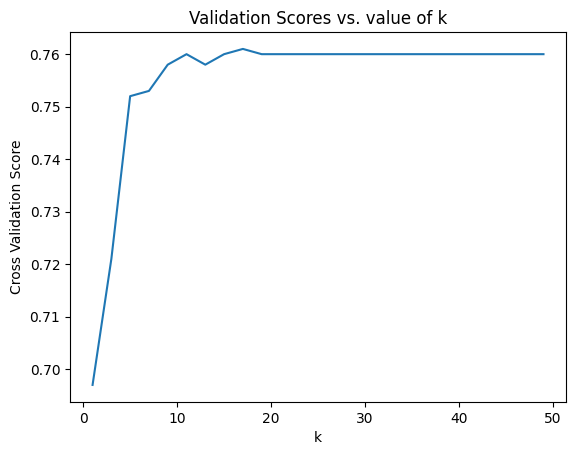

In [ ]:
### ========== TODO : START ========== ###
# part g: use 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
print('Finding the best k...')
k = np.arange(1, 51, 2)
val_scores = []
for value in k:
  clf = KNeighborsClassifier(n_neighbors=value)
  val_scores.append(np.mean(cross_val_score(clf, X, y, cv=5)))

plt.plot(k, val_scores)
plt.title("Validation Scores vs. value of k")
plt.xlabel("k")
plt.ylabel("Cross Validation Score")

print("best k value: ", k[np.argmax(val_scores)], " and corresponding (average) validation score: ", np.max(val_scores))
### ========== TODO : END ========== ###

Investigating depths...
best depth with lowest training error:  20  and corresponding (average) training error:  0.00374999999999992
best depth with lowest validation error:  5  and corresponding (average) validation error:  0.16600000000000004


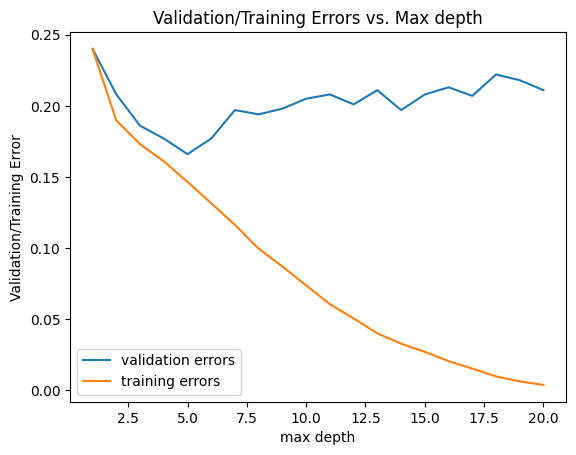

In [ ]:
### ========== TODO : START ========== ###
# part h: investigate decision tree classifier with various depths
print('Investigating depths...')
depths = np.arange(1, 21, 1)
val_errors = []
training_errors = []
for depth in depths:
  clf = DecisionTreeClassifier(criterion='entropy', max_depth = depth)
  cross_val = cross_validate(clf, X, y, cv=5, return_train_score=True)
  val_score = np.mean(cross_val['test_score'])
  val_errors.append(1 - val_score)
  training_score = np.mean(cross_val['train_score'])
  training_errors.append(1 - training_score)

plt.plot(depths, val_errors, label = "validation errors")
plt.plot(depths, training_errors, label = "training errors")
plt.title("Validation/Training Errors vs. Max depth")
plt.xlabel("max depth")
plt.ylabel("Validation/Training Error")
plt.legend()

print("best depth with lowest training error: ", depths[np.argmin(training_errors)],
      " and corresponding (average) training error: ", np.min(training_errors))
print("best depth with lowest validation error: ", depths[np.argmin(val_errors)],
      " and corresponding (average) validation error: ", np.min(val_errors))
### ========== TODO : END ========== ###

In [ ]:
print('Done')